### Business Problem: Develop a customer segmentation to define marketing strategy.

### Statistics Problem: Unsupervised learning // Segmentation // Scientific Approach

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.grid'] = True

import statsmodels.formula.api as smf
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.decomposition import PCA 

In [2]:
data = pd.read_csv('CC_GENERAL.csv')

In [3]:
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [5]:
# profile_report = pandas_profiling.ProfileReport(data)
# profile_report.to_file('Credit_profiling.html')

Insights post profiling report.

* No duplicates in the data
* CustId has unique values, hence, highly cardinal. Will be removed from the data.
* Missing values in MINIMUM_PAYMENTS and CREDIT_LIMIT.
* A lot of Zero values in the data

### Data preparation

In [6]:
data.drop('CUST_ID', axis = 1, inplace = True)

#### Missing values imputation

In [7]:
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

data = data.apply(lambda x: Missing_imputation(x))

#### Handling Outliers

In [8]:
#Outlier treatment
def outlier_capping(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    return x

#Implementing outlier function 
data = data.apply(outlier_capping)

### Advanced Data Preparation

#### 1. Monthly average purchase

In [9]:
data['Monthly_avg_purchase'] = data['PURCHASES'] / data['TENURE']

#### 2. Monthly Cash Advance Amount

In [10]:
data['monthly_cash_adv_amnt'] = data['CASH_ADVANCE'] / data['TENURE']

#### 3. Purchase by type (one-off, installments)

In [11]:
data['Purchase_type'] = np.where((data['ONEOFF_PURCHASES'] > 0) & (data['INSTALLMENTS_PURCHASES'] > 0), 'both',
                                 np.where((data['ONEOFF_PURCHASES'] > 0) & (data['INSTALLMENTS_PURCHASES'] == 0), 'oneoff',
                                          np.where((data['ONEOFF_PURCHASES'] == 0) & (data['INSTALLMENTS_PURCHASES'] > 0), 'installment', 'none')))

#### 4. Average Amount Purchase transcation

In [12]:
data['Purchase_per_transaction'] = data['PURCHASES'] / data['PURCHASES_TRX']

#### 5. Average Cash Advance transaction

In [13]:
data['Cash_advance_per_transaction'] = data['CASH_ADVANCE'] / data['CASH_ADVANCE_TRX']

#### 6. Limit usage (balance to credit limit ratio) - lower your balance-to-limit ratio, the better

In [14]:
data['Limit_usage'] = data['BALANCE'] / data['CREDIT_LIMIT']

#### 7. Payments to minimum payments ratio

In [15]:
data['Payments_to_min_payment'] = data['PAYMENTS'] / data['MINIMUM_PAYMENTS']

In [16]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   float64
 12  CREDIT

In [18]:
#running missing value imputation again

data[['Purchase_per_transaction', 'Cash_advance_per_transaction']] = data[['Purchase_per_transaction', 'Cash_advance_per_transaction']].apply(lambda x: Missing_imputation(x))

In [23]:
#removing original variables as derived variables are created

data.drop(['PURCHASES', 'TENURE', 'CASH_ADVANCE', 'PURCHASES_TRX', 'CASH_ADVANCE_TRX'], axis = 1, inplace = True)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   ONEOFF_PURCHASES                  8950 non-null   float64
 3   INSTALLMENTS_PURCHASES            8950 non-null   float64
 4   PURCHASES_FREQUENCY               8950 non-null   float64
 5   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 6   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 7   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 8   CREDIT_LIMIT                      8950 non-null   float64
 9   PAYMENTS                          8950 non-null   float64
 10  MINIMUM_PAYMENTS                  8950 non-null   float64
 11  PRC_FULL_PAYMENT                  8950 non-null   float64
 12  Monthl

### Advanced Reporting

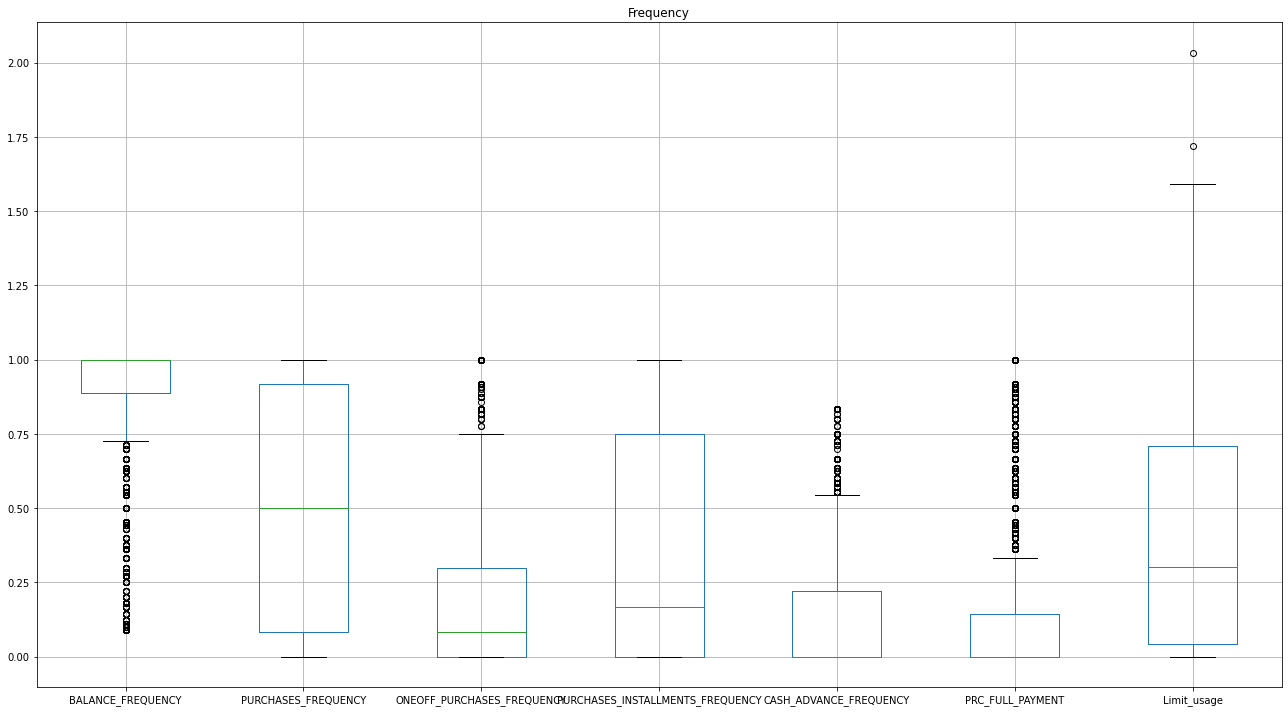

In [25]:
data[['BALANCE_FREQUENCY',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
'PRC_FULL_PAYMENT',
     'Limit_usage']].plot.box(figsize=(18,10),title='Frequency',legend=True);
plt.tight_layout()

#### As Purchase_type is a categorical variable, Creating dummy variables for the same.

In [26]:
data = pd.get_dummies(data, columns=['Purchase_type'], drop_first=True, prefix='purchasetype')

In [27]:
data[['purchasetype_installment']] = pd.to_numeric(data['purchasetype_installment'])
data[['purchasetype_none']] = pd.to_numeric(data['purchasetype_none'])
data[['purchasetype_oneoff']] = pd.to_numeric(data['purchasetype_oneoff'])

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   ONEOFF_PURCHASES                  8950 non-null   float64
 3   INSTALLMENTS_PURCHASES            8950 non-null   float64
 4   PURCHASES_FREQUENCY               8950 non-null   float64
 5   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 6   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 7   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 8   CREDIT_LIMIT                      8950 non-null   float64
 9   PAYMENTS                          8950 non-null   float64
 10  MINIMUM_PAYMENTS                  8950 non-null   float64
 11  PRC_FULL_PAYMENT                  8950 non-null   float64
 12  Monthl

### Feature selection

In [29]:
sc = StandardScaler()
std_model = sc.fit(data)
data_scaled = pd.DataFrame(std_model.transform(data), columns = data.columns)

In [30]:
data_scaled

,BALANCE,BALANCE_FREQUENCY,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT,PAYMENTS,...,PRC_FULL_PAYMENT,Monthly_avg_purchase,monthly_cash_adv_amnt,Purchase_per_transaction,Cash_advance_per_transaction,Limit_usage,Payments_to_min_payment,purchasetype_installment,purchasetype_none,purchasetype_oneoff
0,-0.762856,-0.255968,-0.489121,-0.427513,-0.806490,-0.678661,-0.707313,-0.685371,-0.978415,-0.642945,...,-0.525551,-0.559583,-0.510509,-0.264563,-0.172090,-0.979687,-0.273174,1.720516,-0.543690,-0.514625
1,0.844867,0.132501,-0.489121,-0.568588,-1.221758,-0.678661,-0.916995,0.593147,0.711297,1.089747,...,0.234227,-0.620854,2.704783,-0.208918,2.685695,0.205564,-0.113670,-0.581221,1.839282,-0.514625
2,0.485181,0.520970,0.215778,-0.568588,1.269843,2.673451,-0.916995,-0.685371,0.852106,-0.456289,...,-0.525551,-0.124282,-0.510509,-0.147206,-0.172090,-0.149529,-0.303659,-0.581221,-0.543690,1.943162
3,0.063882,-1.032906,0.877517,-0.568588,-1.014125,-0.399319,-0.916995,-0.259200,0.852106,-0.732573,...,-0.525551,0.341886,-0.407813,9.915389,-0.284426,-0.463809,-0.370128,-0.581221,-0.543690,1.943162
4,-0.367830,0.520970,-0.474534,-0.568588,-1.014125,-0.399319,-0.916995,-0.685371,-0.922091,-0.431298,...,-0.525551,-0.610578,-0.510509,-0.486918,-0.172090,0.842675,-0.184394,-0.581221,-0.543690,1.943162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-0.769165,0.520970,-0.489121,-0.138086,1.269843,-0.678661,1.179833,-0.685371,-0.978415,-0.587964,...,1.183951,-0.246907,-0.510509,-0.258811,-0.172090,-1.014987,0.076281,1.720516,-0.543690,-0.514625
8946,-0.773899,0.520970,-0.489121,-0.124954,1.269843,-0.678661,1.179833,-0.685371,-0.978415,-0.610052,...,-0.525551,-0.235501,-0.510509,-0.248430,-0.172090,-1.041476,-0.310930,1.720516,-0.543690,-0.514625
8947,-0.771756,-0.191225,-0.489121,-0.355053,0.854576,-0.678661,0.760469,-0.685371,-0.978415,-0.696478,...,0.329200,-0.435371,-0.510509,-0.396573,-0.172090,-1.029482,-0.304035,1.720516,-0.543690,-0.514625
8948,-0.776811,-0.191225,-0.489121,-0.568588,-1.221758,-0.678661,-0.916995,0.166976,-1.119224,-0.709234,...,0.329200,-0.620854,-0.474021,-0.208918,-0.680828,-1.019478,-0.306955,-0.581221,1.839282,-0.514625


In [32]:
pca_model = PCA(n_components=21)
pca_model = pca_model.fit(data_scaled)

In [33]:
pca_model.explained_variance_

array([4.60769806, 3.79817782, 2.37262172, 1.82894698, 1.22583405,
       1.06375428, 0.88605784, 0.84536595, 0.76256528, 0.6948684 ,
       0.62417592, 0.49483904, 0.43724324, 0.33874275, 0.28895056,
       0.20612829, 0.18236895, 0.15671038, 0.12953413, 0.03909231,
       0.01867068])

In [34]:
pca_model.explained_variance_ratio_

array([0.21938968, 0.1808454 , 0.11296936, 0.08708298, 0.05836653,
       0.05064931, 0.04218852, 0.04025102, 0.03630857, 0.03308527,
       0.02971934, 0.02356113, 0.02081878, 0.0161288 , 0.01375801,
       0.00981454, 0.00868327, 0.00746157, 0.0061676 , 0.00186133,
       0.00088898])

In [35]:
np.cumsum(np.round(pca_model.explained_variance_ratio_, decimals=4)*100)  #Eigen values

array([ 21.94,  40.02,  51.32,  60.03,  65.87,  70.93,  75.15,  79.18,
        82.81,  86.12,  89.09,  91.45,  93.53,  95.14,  96.52,  97.5 ,
        98.37,  99.12,  99.74,  99.93, 100.02])

The number of components choosen is 12 based on cumulative variance is explaining >89 % and individual component explaining >0.8 variance

In [36]:
pc_final=PCA(n_components=12).fit(data_scaled)
pc_final

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [37]:
PCs = pd.DataFrame(pc_final.transform(data_scaled), columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 'PC11', 'PC12' ])
PCs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-0.955892,-2.334322,-0.317284,0.116174,0.550949,0.265240,0.087080,-0.113261,-0.043367,-0.321877,-0.091110,-0.851390
1,-2.515879,2.559821,0.052500,2.852451,0.095909,-0.829664,1.290659,0.086873,-0.885245,0.698891,-0.392257,0.102062
2,0.959011,0.506860,1.638552,-2.164599,0.213542,-2.178520,0.389713,-0.170836,0.799474,0.049184,0.593447,-0.092509
3,-0.218498,0.478748,5.235792,-1.770516,4.925050,4.163949,-0.973773,0.004593,-4.608146,0.023456,2.165801,-0.437151
4,-1.602505,-0.726509,0.983566,-1.751959,0.188966,-0.344986,0.367373,0.883931,0.569630,0.392723,0.098708,0.673417
...,...,...,...,...,...,...,...,...,...,...,...,...
8945,1.144102,-2.669971,-1.451467,0.466281,0.165417,-0.310893,-0.349271,0.669594,-0.532540,0.708991,0.132659,-0.509945
8946,0.763233,-2.349147,-1.704689,-0.142467,0.489594,-0.168685,0.111217,0.533676,-0.447162,-0.529088,0.351373,-0.600065
8947,0.420431,-2.714411,-1.212348,0.288566,0.449928,-0.277748,-0.125524,0.214471,-0.272354,-0.083314,-0.162818,-0.671877
8948,-2.103723,-1.452754,0.626108,0.302410,-1.682444,0.723393,-0.161590,-0.842585,-0.489754,0.294181,-0.284756,0.203385


In [38]:
#variable reduction
Loadings =  pd.DataFrame((pc_final.components_.T * np.sqrt(pc_final.explained_variance_)).T,columns=data.columns).T

In [39]:
Loadings.column= ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 'P11', 'P12']

In [40]:
#Loadings.to_csv('loadings.csv')

In [45]:
#Build the segmentation using two ways 
#1. Using PC's 2. Using selected variables from each PC's

selected_vars = [
'Monthly_avg_purchase',
'PURCHASES_FREQUENCY',
'INSTALLMENTS_PURCHASES',
'ONEOFF_PURCHASES',
'BALANCE',
'monthly_cash_adv_amnt',
'purchasetype_oneoff',
'PURCHASES_INSTALLMENTS_FREQUENCY',
'Limit_usage',
'Cash_advance_per_transaction',
'purchasetype_none',
'Purchase_per_transaction',
'Payments_to_min_payment',
'BALANCE_FREQUENCY',
'PRC_FULL_PAYMENT'
]

In [46]:
final_input_segmentation = data_scaled[selected_vars]
final_input_segmentation

,Monthly_avg_purchase,PURCHASES_FREQUENCY,INSTALLMENTS_PURCHASES,ONEOFF_PURCHASES,BALANCE,monthly_cash_adv_amnt,purchasetype_oneoff,PURCHASES_INSTALLMENTS_FREQUENCY,Limit_usage,Cash_advance_per_transaction,purchasetype_none,Purchase_per_transaction,Payments_to_min_payment,BALANCE_FREQUENCY,PRC_FULL_PAYMENT
0,-0.559583,-0.806490,-0.427513,-0.489121,-0.762856,-0.510509,-0.514625,-0.707313,-0.979687,-0.172090,-0.543690,-0.264563,-0.273174,-0.255968,-0.525551
1,-0.620854,-1.221758,-0.568588,-0.489121,0.844867,2.704783,-0.514625,-0.916995,0.205564,2.685695,1.839282,-0.208918,-0.113670,0.132501,0.234227
2,-0.124282,1.269843,-0.568588,0.215778,0.485181,-0.510509,1.943162,-0.916995,-0.149529,-0.172090,-0.543690,-0.147206,-0.303659,0.520970,-0.525551
3,0.341886,-1.014125,-0.568588,0.877517,0.063882,-0.407813,1.943162,-0.916995,-0.463809,-0.284426,-0.543690,9.915389,-0.370128,-1.032906,-0.525551
4,-0.610578,-1.014125,-0.568588,-0.474534,-0.367830,-0.510509,1.943162,-0.916995,0.842675,-0.172090,-0.543690,-0.486918,-0.184394,0.520970,-0.525551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-0.246907,1.269843,-0.138086,-0.489121,-0.769165,-0.510509,-0.514625,1.179833,-1.014987,-0.172090,-0.543690,-0.258811,0.076281,0.520970,1.183951
8946,-0.235501,1.269843,-0.124954,-0.489121,-0.773899,-0.510509,-0.514625,1.179833,-1.041476,-0.172090,-0.543690,-0.248430,-0.310930,0.520970,-0.525551
8947,-0.435371,0.854576,-0.355053,-0.489121,-0.771756,-0.510509,-0.514625,0.760469,-1.029482,-0.172090,-0.543690,-0.396573,-0.304035,-0.191225,0.329200
8948,-0.620854,-1.221758,-0.568588,-0.489121,-0.776811,-0.474021,-0.514625,-0.916995,-1.019478,-0.680828,1.839282,-0.208918,-0.306955,-0.191225,0.329200


### K-means clustering

#### Determining K's value

1. Elbow Method

In [47]:
wcss = []
cluster_list = range(1, 11)
for i in cluster_list :
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 40)
    kmeans.fit(final_input_segmentation)
    wcss.append(kmeans.inertia_)

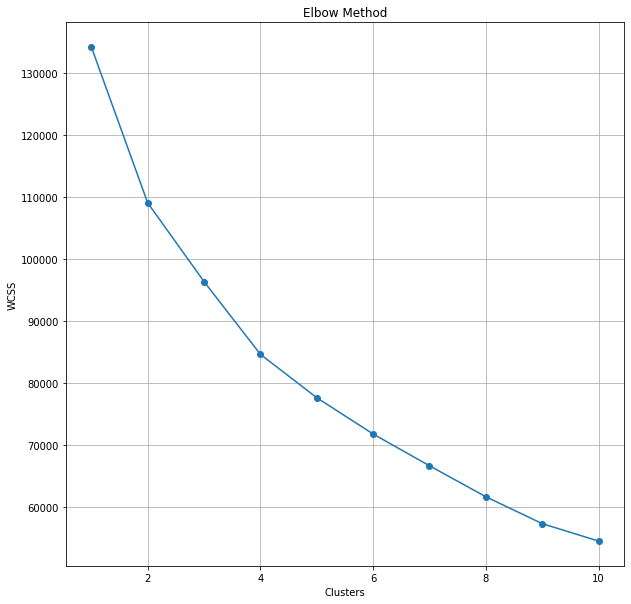

In [48]:
plt.plot(cluster_list, wcss, marker = "o")
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

2. Silhouette Score

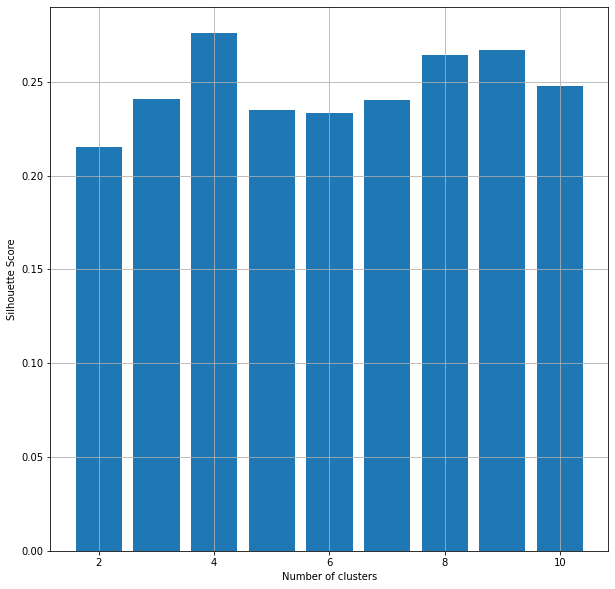

In [49]:
silhouette_scores = [] 

for n_cluster in range(2, 11):
    silhouette_scores.append( 
        silhouette_score(final_input_segmentation, KMeans(n_clusters = n_cluster).fit_predict(final_input_segmentation))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7, 8, 9, 10] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

As per Elbow Method and Silhouette score, optimal number of clusters is 4 or k = 4.

In [50]:
cluster = KMeans(n_clusters=4,random_state=12345)
cluster.fit(final_input_segmentation)
cluster.labels_

array([0, 1, 2, ..., 0, 1, 2])

In [51]:
pd.Series(cluster.labels_).value_counts()

0    4169
1    2229
2    1840
3     712
dtype: int64

In [52]:
final_input_segmentation['km_4'] = cluster.labels_

In [53]:
clusters = final_input_segmentation.groupby('km_4').mean().T
clusters

km_4,0,1,2,3
Monthly_avg_purchase,-0.063651,-0.597552,-0.189746,2.733758
PURCHASES_FREQUENCY,0.628135,-1.154156,-0.450894,1.100510
INSTALLMENTS_PURCHASES,0.191930,-0.547058,-0.565049,2.049054
ONEOFF_PURCHASES,-0.192970,-0.473620,0.080297,2.405122
BALANCE,-0.283437,0.398128,-0.079032,0.617473
monthly_cash_adv_amnt,-0.295593,0.635269,-0.064786,-0.090563
purchasetype_oneoff,-0.514625,-0.508009,1.920455,-0.359287
PURCHASES_INSTALLMENTS_FREQUENCY,0.698728,-0.870984,-0.914683,0.999219
Limit_usage,-0.261589,0.541985,-0.016802,-0.121639
Cash_advance_per_transaction,-0.128263,0.325843,-0.088856,-0.039440


In [54]:
# Percentage of each cluster in the total customer base
s = final_input_segmentation['km_4'].value_counts()
print(s)

print('\n')

percentage = pd.Series((s.values.astype('float')/ final_input_segmentation.shape[0])*100,name='Percentage')
print ("Clusters"),'\n'
print (pd.concat([pd.Series(s.values,name='Size'),percentage],axis=1))

0    4169
1    2229
2    1840
3     712
Name: km_4, dtype: int64


Clusters
   Size  Percentage
0  4169   46.581006
1  2229   24.905028
2  1840   20.558659
3   712    7.955307


In [55]:
import pickle

# now you can save it to a file
with open('segmentation.pkl', 'wb') as f:
    pickle.dump(cluster, f)

#### Apply the changes on the original (un-scaled) data and analysing the data on the basis of clusters.

In [56]:
data_updated = pd.concat([data[selected_vars],pd.Series(cluster.labels_,name='Clusters')],axis=1)

In [57]:
data_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Monthly_avg_purchase              8950 non-null   float64
 1   PURCHASES_FREQUENCY               8950 non-null   float64
 2   INSTALLMENTS_PURCHASES            8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   BALANCE                           8950 non-null   float64
 5   monthly_cash_adv_amnt             8950 non-null   float64
 6   purchasetype_oneoff               8950 non-null   uint8  
 7   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 8   Limit_usage                       8950 non-null   float64
 9   Cash_advance_per_transaction      8950 non-null   float64
 10  purchasetype_none                 8950 non-null   uint8  
 11  Purchase_per_transaction          8950 non-null   float64
 12  Paymen

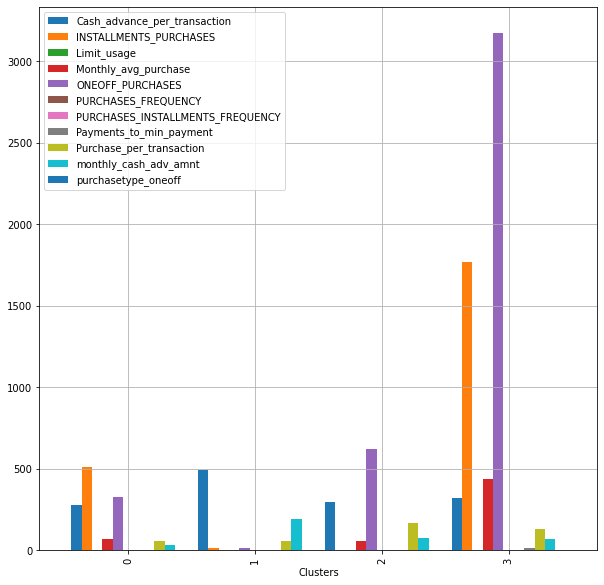

In [58]:
insights = data_updated[data_updated.columns.difference(['BALANCE','BALANCE_FREQUENCY', 'CASH_ADVANCE', 'purchasetype_none', 'TENURE', 'PRC_FULL_PAYMENT', 'PURCHASES_TRX'])].groupby('Clusters').mean()
insights.plot(kind='bar', width = .9)
plt.show()

In [59]:
insights.T

Clusters,0,1,2,3
Cash_advance_per_transaction,279.657704,494.461957,298.297966,321.673239
INSTALLMENTS_PURCHASES,514.287728,14.559789,2.393217,1770.137029
Limit_usage,0.293300,0.575741,0.379338,0.342490
Monthly_avg_purchase,72.297797,3.023458,55.936709,435.265208
ONEOFF_PURCHASES,324.833751,17.002826,624.567239,3174.556669
PURCHASES_FREQUENCY,0.742452,0.027132,0.309385,0.932039
PURCHASES_INSTALLMENTS_FREQUENCY,0.642130,0.018286,0.000919,0.761552
Payments_to_min_payment,4.586515,4.362326,5.020123,15.928909
Purchase_per_transaction,55.584513,55.893783,170.699929,132.131220
monthly_cash_adv_amnt,35.888303,191.330098,74.429950,70.125548


## --------------------------------------------------------------------------------------------------------------------------------

### Insights:

**Cluster 0** : *This cluster represents 46.5% of the total customer base.* This cluster has low Balance to Credit Limit ratio(Limit usage) which is a good sign and as lower is better. Cluster 0 takes average amount Cash Advances, Decent One-off purchases and Installment Purchases. This cluster can be termed as Good customers.

***

**Cluster 1** : *This cluster represents 25% of the total customer base.* This cluster has high *Balance to Credit Limit ratio(Limit usage)* and takes the highest amount of Cash Advances and low number of installments. Has lowest number of recurring purchases in the group.

***

**Cluster 2** : *This cluster represents 20.5% of the total customer base.* This cluster has moderate Balance to Credit Limit ratio(Limit usage). Spends more on One-off Purchases than on Installments. Also, takes decent number of Cash Advances.

***

**Cluster 3** : *This cluster represents 8% of the total customer base.* This cluster has 2nd least Balance to Credit Limit ratio(Limit usage) and are the biggest spenders. Has the highest amount of monthly purchases in the group.

## ---------------------------------------------------------------------------------------------------------------------------------

### Strategies

**Cluster 0** : This is the safest group as they have the best Balance to Credit limit ratio and decent purchasers. We should provide them better interest rates and offers to motivate them to spend more.

***

**Cluster 1** : This group has the poorest Balance to Credit limit ratio which is very risky. The group spends more on Cash advances than Installment purchases. We should focus on getting their Balance to Credit limit ration better and increase their spending power.

***

**Cluster 2** : Decent Balance to Credit limit ratio and focuses more on One-off Purchases than on Installments. We should focus on increasing this groups recurring spends.

***

**Cluster 3** : This group represents 8% of the total customer base and are the highest spenders generating the most revenue. They also have a good Balance to Credit limit ratio. The group can be termed as our Elite customers and we should give better reward points and premium services to motivate them to spend more.

